In [2]:
import torch
import os
import cv2
import torch.nn as nn
import torch.optim as optim
import torchvision
import seaborn as sns
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import models, transforms
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torchvision import models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import warnings
warnings.filterwarnings('ignore')

2024-12-12 03:45:04.150686: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733996704.166290  513243 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733996704.170739  513243 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-12 03:45:04.186548: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
import torch
from torch.utils.data import DataLoader, WeightedRandomSampler
from torchvision.datasets import ImageFolder
import albumentations as A
from albumentations.pytorch import ToTensorV2
import numpy as np


# Define Albumentations augmentations
def augment_image(image):
    aug = A.Compose([
        A.Resize(256, 256),  # Resize images to a slightly larger size
        A.CenterCrop(224, 224),  # Crop the central part
        A.CLAHE(clip_limit=4.0, p=0.5),  # Improve contrast
        A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),  # Adjust brightness and contrast
        A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=15, val_shift_limit=10, p=0.4),  # Adjust color properties
        A.Blur(blur_limit=3, p=0.3),  # Apply slight blur for robustness
        A.GaussNoise(var_limit=(10.0, 50.0), p=0.4),  # Add Gaussian noise
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize using ImageNet stats
        ToTensorV2()  # Convert to PyTorch tensor
    ])
    augmented = aug(image=image)
    return augmented['image']


class AlbumentationsDataset(torch.utils.data.Dataset):
    def __init__(self, dataset):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img, label = self.dataset[idx]
        img = np.array(img)  # Convert PIL to NumPy
        img = augment_image(img)
        return img, label


# Paths to datasets
train_path = 'chest_xray/train'
val_path = 'chest_xray/val'
test_path = 'chest_xray/test'


# Load datasets with Albumentations
trainset = AlbumentationsDataset(ImageFolder(root=train_path))
valset = AlbumentationsDataset(ImageFolder(root=val_path))
testset = AlbumentationsDataset(ImageFolder(root=test_path))

# Calculate class weights for oversampling
train_labels = [label for _, label in trainset]
class_counts = np.bincount(train_labels)
class_weights = 1.0 / class_counts  # Weight inversely proportional to class frequency
weights = [class_weights[label] for label in train_labels]

# Create a WeightedRandomSampler for oversampling
sampler = WeightedRandomSampler(weights, num_samples=len(weights), replacement=True)

# DataLoaders
trainloader = DataLoader(trainset, batch_size=32, sampler=sampler, num_workers=4, pin_memory=True)
valloader = DataLoader(valset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)
testloader = DataLoader(testset, batch_size=32, shuffle=False, num_workers=4)

print("DataLoaders created with oversampling for training.")

DataLoaders created with oversampling for training.


In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torchvision.models import resnet50, ResNet50_Weights

# Load the pretrained ResNet50 model
model = resnet50(weights=ResNet50_Weights.DEFAULT)

# Replace the final fully connected layer for binary classification
in_features = model.fc.in_features
model.fc = nn.Linear(in_features, 1)  # Output for binary classification

# Check device
device = torch.device('cuda')
num_gpus = torch.cuda.device_count()
model = nn.DataParallel(model)
model = model.to(device)

# Freeze feature extractor
for name, param in model.module.named_parameters():
    if 'fc' not in name:  # Freeze all layers except the final fc layer
        param.requires_grad = False

# Define criterion and optimizer for the classifier
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.module.fc.parameters(), lr=0.001)  # Only update fc layer parameters

print(f"Using {num_gpus} GPUs")

Using 8 GPUs


In [6]:
class EarlyStopping:
    def __init__(self, patience=10, delta=0, mode='min', restore_best_weights=True):
        self.patience = patience
        self.delta = delta
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.best_model_weights = None
        self.best_epoch = 0
        self.restore_best_weights = restore_best_weights

    def __call__(self, val_loss, model, current_epoch):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.best_model_weights = model.state_dict()
            self.best_epoch = current_epoch
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.best_model_weights = model.state_dict()
            self.best_epoch = current_epoch
            self.counter = 0

    def restore_weights(self, model):
        if self.restore_best_weights and self.best_model_weights is not None:
            model.load_state_dict(self.best_model_weights)




# Training and validation loop
train_loss_history = []
val_loss_history = []
train_acc_history = []
val_acc_history = []

epochs = 10
early_stopping = EarlyStopping(patience=10, restore_best_weights=True)

for epoch in range(epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    # Training loop
    for i, (inputs, labels) in enumerate(trainloader):
        inputs, labels = inputs.to(device), labels.to(device).float().unsqueeze(1)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        preds = (torch.sigmoid(outputs) > 0.5).float()
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / len(trainloader)
    train_acc = correct / total
    train_loss_history.append(train_loss)
    train_acc_history.append(train_acc)

    # Validation loop
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for inputs, labels in valloader:
            inputs, labels = inputs.to(device), labels.to(device).float().unsqueeze(1)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            preds = (torch.sigmoid(outputs) > 0.5).float()
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    val_loss /= len(valloader)
    val_acc = val_correct / val_total
    val_loss_history.append(val_loss)
    val_acc_history.append(val_acc)

    print(f"Epoch [{epoch+1}/{epochs}] - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    early_stopping(val_loss, model, epoch + 1)
    if early_stopping.early_stop:
        print(f"Early stopping at epoch {epoch+1}")
        break

# Restore the best model weights
early_stopping.restore_weights(model)

# Print the best epoch
print(f"Best epoch based on validation loss: {early_stopping.best_epoch}")

Epoch [1/10] - Train Loss: 0.6217, Train Acc: 0.6555, Val Loss: 0.6118, Val Acc: 0.6875
Epoch [2/10] - Train Loss: 0.5358, Train Acc: 0.7444, Val Loss: 0.6603, Val Acc: 0.5625
Epoch [3/10] - Train Loss: 0.5024, Train Acc: 0.7646, Val Loss: 0.5745, Val Acc: 0.6250
Epoch [4/10] - Train Loss: 0.4916, Train Acc: 0.7659, Val Loss: 0.5794, Val Acc: 0.6875
Epoch [5/10] - Train Loss: 0.4753, Train Acc: 0.7715, Val Loss: 0.4981, Val Acc: 0.6875
Epoch [6/10] - Train Loss: 0.4680, Train Acc: 0.7736, Val Loss: 0.6989, Val Acc: 0.5000
Epoch [7/10] - Train Loss: 0.4509, Train Acc: 0.7901, Val Loss: 0.5337, Val Acc: 0.6250
Epoch [8/10] - Train Loss: 0.4452, Train Acc: 0.7870, Val Loss: 0.8769, Val Acc: 0.6250
Epoch [9/10] - Train Loss: 0.4446, Train Acc: 0.7928, Val Loss: 0.5035, Val Acc: 0.8125
Epoch [10/10] - Train Loss: 0.4233, Train Acc: 0.8123, Val Loss: 0.6296, Val Acc: 0.6875
Best epoch based on validation loss: 5


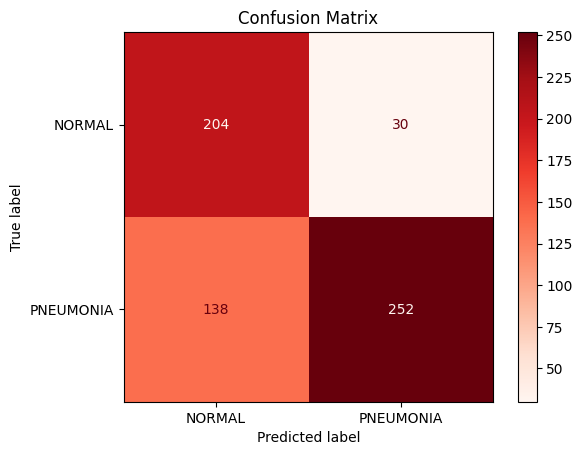

              precision    recall  f1-score   support

      Normal       0.57      0.86      0.69       234
   Pneumonia       0.88      0.61      0.72       390

    accuracy                           0.71       624
   macro avg       0.73      0.74      0.70       624
weighted avg       0.76      0.71      0.71       624



In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Switch the model to evaluation mode
model.eval()

# Collect true and predicted labels
y_true = []
y_pred = []

with torch.no_grad():
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = torch.sigmoid(model(inputs))
        preds = (outputs > 0.7).cpu().numpy()
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds)

# Convert lists to numpy arrays
y_true = np.array(y_true).flatten()
y_pred = np.array(y_pred).flatten()

# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Test evaluation
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device).float().unsqueeze(1)
        outputs = model(inputs)
        preds = (torch.sigmoid(outputs) > 0.7).float()
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['NORMAL', 'PNEUMONIA'])
disp.plot(cmap=plt.cm.Reds)
plt.title("Confusion Matrix")
plt.show()

from torch.utils.data import Dataset
from PIL import Image
import numpy as np

class AlbumentationsDataset(Dataset):
    def __init__(self, filepaths, labels, augment_function, class_names=None):
        self.filepaths = filepaths
        self.labels = labels
        self.augment_function = augment_function
        self.classes = class_names  # Class names for evaluation

    def __len__(self):
        return len(self.filepaths)

    def __getitem__(self, idx):
        image = Image.open(self.filepaths[idx]).convert("RGB")
        label = self.labels[idx]

        # Apply augmentations
        if self.augment_function:
            image = self.augment_function(image=np.array(image))  # Call the provided augment function

        return image, label


class_names = ['Normal', 'Pneumonia']  # Replace with actual class names

testset = AlbumentationsDataset(
    filepaths=test_path,  # Paths to test images
    labels=labels,        # Corresponding labels
    augment_function=augment_image,  # Use your defined function
    class_names=class_names
)

from sklearn.metrics import classification_report

# Evaluate the model and populate predictions
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device).float().unsqueeze(1)
        outputs = model(inputs)
        preds = (torch.sigmoid(outputs) > 0.7).float()
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Print the classification report
print(classification_report(all_labels, all_preds, target_names=testset.classes))

In [9]:
# Unfreeze the entire model
if hasattr(model, 'module'):  # If using DataParallel
    for param in model.module.parameters():
        param.requires_grad = True
else:  # If not using DataParallel
    for param in model.parameters():
        param.requires_grad = True

# Define a new optimizer with a lower learning rate
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [10]:
class EarlyStopping:
    def __init__(self, patience=10, delta=0, mode='min', restore_best_weights=True):
        self.patience = patience
        self.delta = delta
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.best_model_weights = None
        self.best_epoch = 0
        self.restore_best_weights = restore_best_weights

    def __call__(self, val_loss, model, current_epoch):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.best_model_weights = model.state_dict()
            self.best_epoch = current_epoch
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.best_model_weights = model.state_dict()
            self.best_epoch = current_epoch
            self.counter = 0

    def restore_weights(self, model):
        if self.restore_best_weights and self.best_model_weights is not None:
            model.load_state_dict(self.best_model_weights)




# Training and validation loop
train_loss_history = []
val_loss_history = []
train_acc_history = []
val_acc_history = []

epochs = 10
early_stopping = EarlyStopping(patience=10, restore_best_weights=True)

for epoch in range(epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    # Training loop
    for i, (inputs, labels) in enumerate(trainloader):
        inputs, labels = inputs.to(device), labels.to(device).float().unsqueeze(1)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        preds = (torch.sigmoid(outputs) > 0.5).float()
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / len(trainloader)
    train_acc = correct / total
    train_loss_history.append(train_loss)
    train_acc_history.append(train_acc)

    # Validation loop
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for inputs, labels in valloader:
            inputs, labels = inputs.to(device), labels.to(device).float().unsqueeze(1)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            preds = (torch.sigmoid(outputs) > 0.5).float()
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    val_loss /= len(valloader)
    val_acc = val_correct / val_total
    val_loss_history.append(val_loss)
    val_acc_history.append(val_acc)

    print(f"Epoch [{epoch+1}/{epochs}] - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    early_stopping(val_loss, model, epoch + 1)
    if early_stopping.early_stop:
        print(f"Early stopping at epoch {epoch+1}")
        break

# Restore the best model weights
early_stopping.restore_weights(model)

# Print the best epoch
print(f"Best epoch based on validation loss: {early_stopping.best_epoch}")


Epoch [1/10] - Train Loss: 0.3104, Train Acc: 0.8579, Val Loss: 0.5361, Val Acc: 0.7500
Epoch [2/10] - Train Loss: 0.1731, Train Acc: 0.9306, Val Loss: 0.2317, Val Acc: 0.8750
Epoch [3/10] - Train Loss: 0.1239, Train Acc: 0.9538, Val Loss: 0.4186, Val Acc: 0.8750
Epoch [4/10] - Train Loss: 0.0978, Train Acc: 0.9618, Val Loss: 0.3215, Val Acc: 0.8125
Epoch [5/10] - Train Loss: 0.0774, Train Acc: 0.9714, Val Loss: 0.2561, Val Acc: 0.8750
Epoch [6/10] - Train Loss: 0.0665, Train Acc: 0.9757, Val Loss: 0.1252, Val Acc: 0.9375
Epoch [7/10] - Train Loss: 0.0541, Train Acc: 0.9797, Val Loss: 0.1753, Val Acc: 0.9375
Epoch [8/10] - Train Loss: 0.0651, Train Acc: 0.9762, Val Loss: 0.2891, Val Acc: 0.8125
Epoch [9/10] - Train Loss: 0.0423, Train Acc: 0.9860, Val Loss: 0.0668, Val Acc: 1.0000
Epoch [10/10] - Train Loss: 0.0510, Train Acc: 0.9818, Val Loss: 0.5199, Val Acc: 0.8125
Best epoch based on validation loss: 9


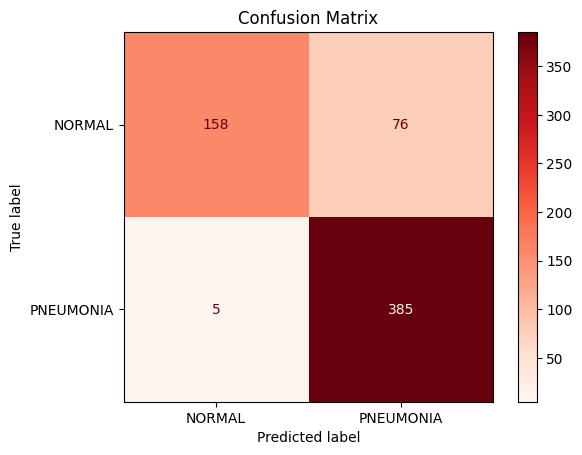

              precision    recall  f1-score   support

      Normal       0.94      0.65      0.77       234
   Pneumonia       0.82      0.97      0.89       390

    accuracy                           0.85       624
   macro avg       0.88      0.81      0.83       624
weighted avg       0.87      0.85      0.85       624



In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Switch the model to evaluation mode
model.eval()

# Collect true and predicted labels
y_true = []
y_pred = []

with torch.no_grad():
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = torch.sigmoid(model(inputs))
        preds = (outputs > 0.7).cpu().numpy()
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds)

# Convert lists to numpy arrays
y_true = np.array(y_true).flatten()
y_pred = np.array(y_pred).flatten()

# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Test evaluation
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device).float().unsqueeze(1)
        outputs = model(inputs)
        preds = (torch.sigmoid(outputs) > 0.7).float()
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['NORMAL', 'PNEUMONIA'])
disp.plot(cmap=plt.cm.Reds)
plt.title("Confusion Matrix")
plt.show()

from torch.utils.data import Dataset
from PIL import Image
import numpy as np

class AlbumentationsDataset(Dataset):
    def __init__(self, filepaths, labels, augment_function, class_names=None):
        self.filepaths = filepaths
        self.labels = labels
        self.augment_function = augment_function
        self.classes = class_names  # Class names for evaluation

    def __len__(self):
        return len(self.filepaths)

    def __getitem__(self, idx):
        image = Image.open(self.filepaths[idx]).convert("RGB")
        label = self.labels[idx]

        # Apply augmentations
        if self.augment_function:
            image = self.augment_function(image=np.array(image))  # Call the provided augment function

        return image, label


class_names = ['Normal', 'Pneumonia']  # Replace with actual class names

testset = AlbumentationsDataset(
    filepaths=test_path,  # Paths to test images
    labels=labels,        # Corresponding labels
    augment_function=augment_image,  # Use your defined function
    class_names=class_names
)

from sklearn.metrics import classification_report

# Evaluate the model and populate predictions
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device).float().unsqueeze(1)
        outputs = model(inputs)
        preds = (torch.sigmoid(outputs) > 0.7).float()
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Print the classification report
print(classification_report(all_labels, all_preds, target_names=testset.classes))
